# Visualize

## Settings and Imports

In [1]:
#Basic Imports
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

#PyTorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
#Additional layers for KeypointRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNHeads
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor

In [2]:
#Own Code
from configs import training_configs, model_configs, path_configs
from dataset import dataset,dataset_transforms
from model_arch import keypoint_model

In [3]:
#Settings

%matplotlib inline

#autoreload other packages when code changed
%load_ext autoreload
%autoreload 2

# Print out every value 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display,clear_output

# suppress warnings
#import warnings
#warnings.filterwarnings('ignore')

In [4]:
#move model to cuda if available 
if torch.cuda.is_available():
    print("GPU will be used")
    device = torch.device('cuda') 
else:
    print("No GPU available")
    device = torch.device('cpu')

#for visulaization we process the tensors on cpu
cpu_device = torch.device('cpu')

GPU will be used


## Datasets

We can create a test dataset, which we will use for evaluation/visualization

In [5]:
test_data = dataset.Dataset(mode='test', limit_handedness='all')

loading annotations into memory...
Done (t=32.31s)
creating index...
index created!


## KeypointRCNN

We need the same model architecture as we already used in the training. Thus we execute the same steps for model creation, as we used in the Training process

In [6]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn()
num_classes = 4
# get number of input features (which will be passed from the backbone to the classifier)
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one()
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

num_out_channels = model.backbone.out_channels
keypoint_layers = tuple(512 for _ in range(8))
model.roi_heads.keypoint_head = KeypointRCNNHeads(num_out_channels, keypoint_layers)

num_keypoints = 42 #21 per hand
keypoint_dim_reduced = 512
model.roi_heads.keypoint_predictor = KeypointRCNNPredictor(keypoint_dim_reduced,num_keypoints)

In [7]:
%%capture
model.load_state_dict(torch.load(path_configs.KEYPOINT_RCNN_PATH))
model.eval()
model.to(device)

In [8]:
@torch.no_grad()
def predict_and_viz_keypoints_keypointRCNN(model,img):
    #create figures and axes 
    #we need the ax object for the patch(bbox)
    fig, ax = plt.subplots()

    #display image
    ax.imshow(img.permute(1, 2, 0))
    
    #add dimension to img (Pytorch expects [B,C,H,W] but image is only [C,H,W])
    #also move to GPU if available
    prediction = model([img.to(device)])[0]

    bbox = prediction['boxes'][0].to(cpu_device)
    keypoints = prediction['keypoints'][0].to(cpu_device)

    #Plot keypoints
    ax.scatter(keypoints[:, 0], keypoints[:, 1], marker="x", color="red", s=50)

    bbox_corner = (bbox[0],bbox[1])
    bbox_width = bbox[2]-bbox[0]
    bbox_height = bbox[3]-bbox[1]
    bbox_rectangle = patches.Rectangle(bbox_corner,bbox_width,bbox_height,linewidth=1, edgecolor='green', facecolor='none')
    ax.add_patch(bbox_rectangle)

    return prediction

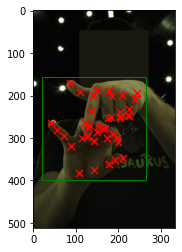

In [32]:
#get random image from test set 
index = random.randint(0, len(test_data))
img, _ = test_data[index]
prediction = predict_and_viz_keypoints_keypointRCNN(model,img)

## FasterRCNN + Own Keypoint Detection Head

We need the same model architecture as we already used in the training. Thus we execute the same steps for model creation, as we used in the Training process.  
This applies to FasterRCNN model and both keypoint detection models (single + interacting)

In [10]:
model_fasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 4 #right, left, interacting hands and background
# get number of input features (which will be passed from the backbone to the classifier)
in_features = model_fasterRCNN.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one()
model_fasterRCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
%%capture
model_fasterRCNN.load_state_dict(torch.load(path_configs.FASTER_RCNN_PATH))
model_fasterRCNN.eval()
model_fasterRCNN.to(device)

In [12]:
%%capture
model_keypoints_interacting = keypoint_model.get_keypoint_model(num_keypoints= 42)
model_keypoints_interacting.load_state_dict(torch.load(path_configs.KEYPOINT_INTERACTING_PATH))
model_keypoints_interacting.eval()
model_keypoints_interacting.to(device)


model_keypoints_single = keypoint_model.get_keypoint_model(num_keypoints= 21)
model_keypoints_single.load_state_dict(torch.load(path_configs.KEYPOINT_SINGLE_PATH))
model_keypoints_single.eval()
model_keypoints_single.to(device)

In [13]:
@torch.no_grad()
def predict_and_viz_keypoints_fasterRCNN(model_faster,model_single,model_interacting,img):
    #create figures and axes 
    #we need the ax object for the patch(bbox)
    fig, ax = plt.subplots()

    #display image
    ax.imshow(img.permute(1, 2, 0))
    
    #add dimension to img (Pytorch expects [B,C,H,W] but image is only [C,H,W])
    #also move to GPU if available
    prediction = model_faster([img.to(device)])[0]
    label = prediction['labels'][0].to(cpu_device)
    bbox = prediction['boxes'][0].to(cpu_device)
    
    #Plot bbox
    bbox_corner = (bbox[0],bbox[1])
    bbox_width = bbox[2]-bbox[0]
    bbox_height = bbox[3]-bbox[1]
    bbox_rectangle = patches.Rectangle(bbox_corner,bbox_width,bbox_height,linewidth=1, edgecolor='green', facecolor='none')
    ax.add_patch(bbox_rectangle)
    
    #crop and resize image
    img = transforms.functional.resized_crop(img,int(bbox[1]),int(bbox[0]),int(bbox_width),int(bbox_height), size =model_configs.INPUT_IMG_SHAPE )
    #convert to batch
    img = img[None,:]
    
    #predict keypoints
    if label in (1,2): #single_hand
        keypoints = model_keypoints_single(img.to(device))     
    else: #interacting_hands
        keypoints = model_keypoints_interacting(img.to(device))

    #keypoints should be transformes to the og size
    #thus scale with the size of bbox and afterwards add the borders
    keypoints = torch.reshape(keypoints,(-1,2))
    keypoints[:,0] *= bbox_width
    keypoints[:,0] += bbox[0]
    keypoints[:,1] *= bbox_height
    keypoints[:,1] += bbox[1]

    #Plot keypoints
    keypoints=keypoints.to(cpu_device)
    ax.scatter(keypoints[:, 0], keypoints[:, 1], marker="x", color="red", s=50)

    return prediction

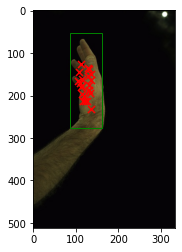

In [74]:
#get random image from test set 
index = random.randint(0, len(test_data))
img, _ = test_data[index]
prediction = predict_and_viz_keypoints_fasterRCNN(model_faster = model_fasterRCNN,
                                                model_single=model_keypoints_single,
                                                model_interacting=model_keypoints_interacting,
                                                img=img)

## YOLOv5

The Yolov5 model could be used as an alternative for the fasterRCNN model  

The Yolo model excepts the path of the image, which would make integration with the other model more complex. Thus we only test if the bboxes and classes work

In [21]:
#load yolo model
model_yolo = torch.hub.load('ultralytics/yolov5','custom',path=path_configs.YOLO_MODEL_PATH)

Using cache found in C:\Users\user/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-5-29 Python-3.10.4 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [27]:
def visualize_bbox_yolo(model, img_path):
    #read image for visualization
    img = Image.open(img_path)
    
    #create figures and axes 
    #we need the ax object for the patch(bbox)
    fig, ax = plt.subplots()

    #display image
    ax.imshow(img)
    
    #prediction
    results = model(img_path).pandas().xyxy[0]

    #print bboxes
    for xmin, ymin, xmax, ymax in zip(results['xmin'],results['ymin'],results['xmax'],results['ymax']):
        bbox_corner = (xmin,ymin)
        bbox_width = xmax - xmin
        bbox_height = ymax - ymin
        bbox_rectangle = patches.Rectangle(bbox_corner,bbox_width,bbox_height,linewidth=1, edgecolor='green', facecolor='none')
        ax.add_patch(bbox_rectangle)


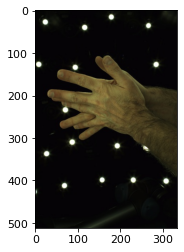

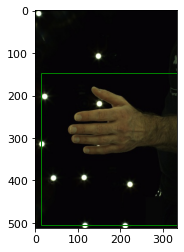

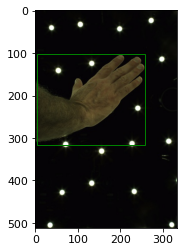

In [28]:
img_paths = ['./data/images/test/Capture0/ROM02_Interaction_2_Hand/cam400262/image21743.jpg',
        './data/images/test/Capture0/ROM03_LT_No_Occlusion/cam400348/image15368.jpg',
        './data/images/test/Capture0/ROM05_RT_Wrist_ROM/cam400487/image19637.jpg']

for path in img_paths:
    visualize_bbox_yolo(model=model_yolo, img_path=path)